# Large-scale Distributed $k$-means Algorithm

In this Notebook, we'll focus on the development of a simple distributed algorithm. As for the Notebook on SGD, we focus on iterative algorithms, which eventually converge to a desired solution.

In what follows, we'll proceed with the following steps:

* We first introduce formally the $k$-means algorithm
* Then we focus on a serial implementation. To do this, we'll first generate some data using scikit. In passing, we'll also use the $k$-means implementation in scikit to have a baseline to compare against.
* Subsequently, we will focus on some important considerations and improvements to the serial implementation of $k$-means.
* At this point, we'll design our distributed version of the $k$-means algorithm using pyspark, and re-implement the enhancements we designed for the serial version 

#### References:
* https://en.wikipedia.org/wiki/K-means_clustering
* http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/clustering/kmeans.ipynb
* https://apache.googlesource.com/spark/+/master/examples/src/main/python/kmeans.py
* https://github.com/castanan/w2v/blob/master/ml-scripts/w2vAndKmeans.py


#### Preamble code

In [83]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.datasets.samples_generator import make_blobs
import time

# Preliminaries: the $k$-means algorithm

$k$-means clustering aims to partition $n$ $d-$dimensional observations into $k$ clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells.
The problem is computationally difficult (NP-hard); however, there are efficient heuristic algorithms that are commonly employed and converge quickly to a local optimum. In this Notebook we'll focus on one of them in particular: the Lloyd algorithm.

The $k$-means problem can be formalized as follows. Given a set of observations $(x_1, x_2, \cdots, x_n)$, where each observation is a $d$-dimensional real vector, $k$-means clustering aims to partition the $n$ observations into $k \leq n$ sets $S = \{S_1, S_2, \cdots, S_k\}$ so as to minimize the within-cluster sum of squares (WCSS) (i.e. variance). 
The objective is to find:

$$
\arg \min_S \sum_{i=1}^{k} \sum_{x \in S_i} || \boldsymbol{x} - \boldsymbol{\mu_i} ||^2
$$

The most common algorithm uses an iterative refinement technique. Given an initial set of $k$ centroids $\mu_1^{(1)}, \cdots, \mu_k^{(1)}$ , the algorithm proceeds by alternating between two steps: in the **assignment step**, observations are associated to the closest **centroid**, in terms of squared Euclidean distance; in the **update step** new centroids are computed based on the new points associated to each centroid. Note: $\mu_i^{(t)}$ stands for the $i$-th centroid as of the $t$-th iteration. So $\mu_1^{(1)}$ is the centroid 1 at iteration 1.

## Algorithm pseudo-code
It is important to work on a principled approach to the design of large-scale algorithms, and this starts with using good data structures and scientific libraries, such as ```numpy``` and ```scipy```. In particular, we will focus on the use of ```numpy``` arrays, which come with efficient methods for array operations. A pseudo-code for the $k$-means algorithm is specified below:

```python
def kmeans(X, k, maxiter, seed=None):
    """
    specify the number of clusters k and
    the maximum iteration to run the algorithm
    """

    # randomly choose k data points as initial centroids
    centroids = X[rand_indices]
    
    for itr in range(maxiter):
        # ---------------
        # ASSIGNMENT STEP
        # ---------------
        # compute the distance matrix between each data point and the set of centroids
        distance_matrix = # row Index = data point Index; col Index = centroid Index; value=distance
        # assign each data point to the closest centroid
        cluster_assignment = # array Index = data point Index; array value = closest centroid Index
        
        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = ...
        
        # STOP CONDITION
        # if centroids == new_centroids => stop
 
    
```

# Synthetic data generation: working in bi-dimensional spaces

Next, we use sklearn to generate some synthetic data to test our algorithm.

In [84]:
X, y = make_blobs(n_samples = 300, centers = 4,
                  random_state = 0, cluster_std = 0.6)

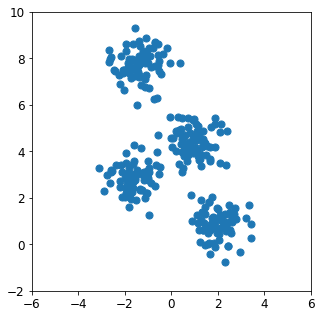

In [85]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 5, 6 
plt.rcParams['font.size'] = 12

# scatter plot
plt.scatter(X[:, 0], X[:, 1], s = 50)
plt.ylim(-2, 10)
plt.xlim(-6, 6)
plt.gca().set_aspect('equal')
plt.show()

<div class="alert alert-block alert-info">
<strong>Question 1.</strong> Implement your own version of k-means, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to perform k-means clustering. The function should accept as inputs: the training data x, the number of clusters k, and the iteration budget you allocate to the algorithm. Additional arguments might include the use of a random seed to initialize centroids.</li>
    <li>The function should output the centroids, and the cluster assignment, that is, to which centroid each data point is assigned to</li>
    <li> Optionally, keep track of the position of the centroids, for each iteration.</li>
</ul>

<br>
Once the ```kmeans``` function is defined, you can generate input data according to the cell above, that uses scikitlearn.
<br>

The output of your cell should contain the following information:
<ul>
    <li> Print the number of data points that belong to each cluster</li>
    <li> Plot the clustered data points:</li>
    <ul>
        <li>Using different colors for each cluster</li>
        <li>Plot the centroid positions for each cluster</li>
    </ul>
</ul>
</div>

In [86]:
def plot_kmeans(data, labels, centroids, centroids_Hist=None):
    '''
    Plot the clustered data of Kmeans algorithm.
    
    Arguments:
    data             --- the input data
    labels           --- label for each data point applied Kmeans
    centroids        --- centers for each cluster applied Kmeans
    centroids_Hist   --- a list contains the centroid's position for each iteration
    
    '''
    
    # figure configuration
    plt.rcParams['figure.figsize'] = 8, 6 
    plt.rcParams['font.size'] = 12
    xmin = min(X[:,0])
    xmax = max(X[:,0])
    ymin = min(X[:,1])
    ymax = max(X[:,1])
    
    plt.ylim(ymin - 1, ymax + 1)
    plt.xlim(xmin - 1, xmax + 1)
    plt.gca().set_aspect('equal')
    
    # scatter plot
    plt.scatter(data[:,0], data[:,1], c = labels)
    plt.scatter(centroids[:,0], centroids[:,1], c = 'r', marker="s")
    if centroids_Hist is not None:
        for i in range(len(centroids)):
            plt.plot(centroids_Hist[:,i,0], centroids_Hist[:,i,1], c = 'b', marker=">")
    plt.show()

In [87]:
import random
def kmeans(X, k, maxiter, seed=None):
    '''
    An implement of Kmeans algorithm
    
    Arguments:
    X                      --- data
    k                      --- number of expected clusters
    max_Iter               --- number of iterations that Kmeans should run
    seed                   --- integer starting value for seed() method
    
    Return:
    cluster_assignment     --- cluster label of data point
    new_centroids          --- updated centroids
    centroids_Hist         --- a list contains the centroid's position for each iteration.
    
    '''
    if seed is not None:
        np.random.seed(i)
    
    # randomly choose k data points as initial centroids
    rand_indices = random.sample(range(len(X)), k)
    init_centroids = X[rand_indices]

    centroids_Hist = [init_centroids]
    old_centroids = init_centroids
    for itr in range(maxiter):
        # ---------------
        # ASSIGNMENT STEP
        # ---------------
        # compute the distance matrix between each data point and the set of centroids
        distance_matrix = pairwise_distances(X, old_centroids, metric='euclidean')
        # assign each data point to the closest centroid
        cluster_assignment = np.argmin(distance_matrix, axis=1)

        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = np.empty((k,X.shape[1]))
        for idx in range(k):
            Xk = X[cluster_assignment == idx]
            new_centroids[idx] = np.mean(Xk, axis=0)

        # STOP CONDITION
        # if the current and previous centroids are equal then stop algorithm
        if np.array_equal(new_centroids, old_centroids):
            break
        old_centroids = new_centroids
        centroids_Hist.append(new_centroids)
    return cluster_assignment, new_centroids, np.array(centroids_Hist)

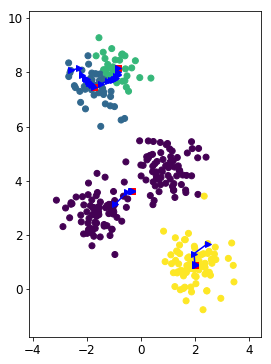

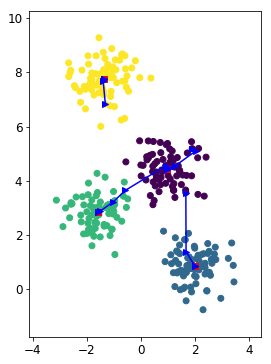

In [89]:
# Parameter configuration
Nb_cluster =  4
numIterations = 100
data = X


# Run 2 cases with different initial centroids
for _ in range(2):
    # apply Kmeans alogorithm onto given dataset
    labels, centers, centers_Hist = kmeans(data, Nb_cluster, numIterations)
    # print('Centers found by k-means algorithm:\n', centers)
    # plot the clustered dataset
    plot_kmeans(data, labels, centers, centers_Hist)

# Comment:
* K-means clustering is a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features input and initial estimates for the Κ centroids, which can either be randomly generated or randomly selected from the data set.

* We assume that the number of clusters in the given dataset is 4. The above two diagrams are respective to two different initial centroids. As we can see, the performance heavily depends on centroids initialization. Choosing the poor random initial centroids will take longer to converge or get stuck on local optima which may result in bad clustering. The k-means performance using (below) scikit-learn library is usually good and then can help to verify the implemented algorithm correctness.

<div class="alert alert-block alert-info">
<strong>Question 2.</strong> Use the built-in k-means implementation in sklearn and determine centroids and clusters.

Follow the guidelines below:

<ul>
    <li> Use the KMeans algorithm from sklearn</li>
    <li> Use the fit_predict method to cluster data</li>
    <li> Use the cluster_centers_ method to retrieve centroids</li>
</ul>

The output of your cell should contain the following information:
<ul>
    <li> Plot the clustered data points, using the same code your have produced for Question.1</li>
    <ul>
        <li>Using different colors for each cluster</li>
        <li>Plot the centroid positions for each cluster</li>
    </ul>
</ul>
</div>

Centers found by scikit-learn:
 [[ 1.98258281  0.86771314]
 [ 0.94973532  4.41906906]
 [-1.37324398  7.75368871]
 [-1.58438467  2.83081263]]


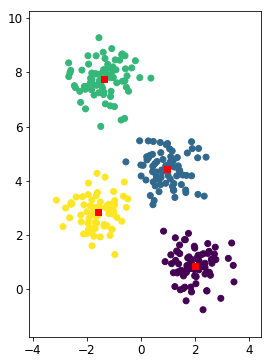

In [90]:
# implement K-means algorithm using sklearn 
skl_kmeans = KMeans(Nb_cluster, random_state=0)
skl_labels = skl_kmeans.fit_predict(data)
skl_centers = skl_kmeans.cluster_centers_
print('Centers found by scikit-learn:\n', skl_centers)
plot_kmeans(data, skl_labels, skl_centers)

<div class="alert alert-block alert-info">
<strong>Question 3.</strong> Use the sklearn dataset API to generate alternative synthetic data to test your k-means algorithm implementation.

Follow the guidelines from this document: http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py


The output of your cell should contain the following information:
<ul>
    <li> Plot the new synthetic dataset you generated
    <li> Plot the clustered data points, using the same code your have produced for Question.1</li>
    <ul>
        <li>Using different colors for each cluster</li>
        <li>Plot the centroid positions for each cluster</li>
    </ul>
</ul>
</div>

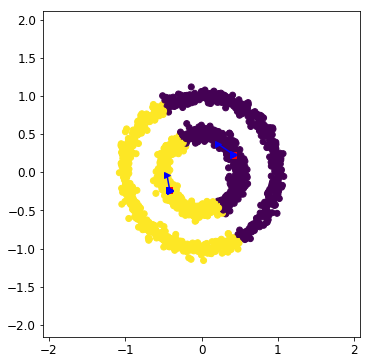

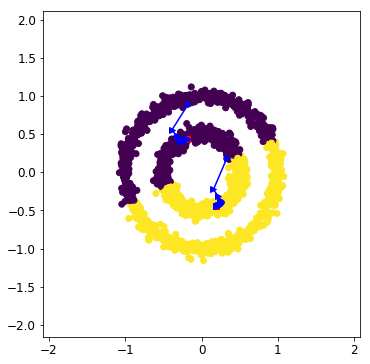

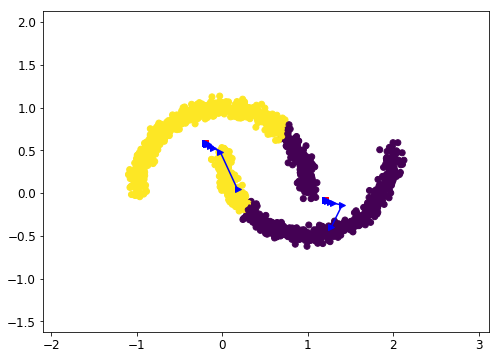

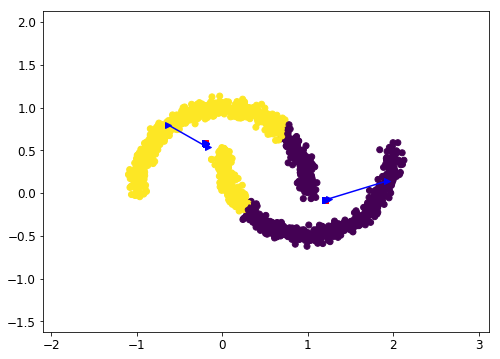

In [92]:
from sklearn import datasets
n_samples = 1500

# generate different synthetic datasets
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    # Parameter configuration
    X, y = dataset
    Nb_cluster =  2
    numIterations = 100
    data = X

    # Run 2 cases with different initial centroids
    for _ in range(2):
        # apply Kmeans alogorithm onto given dataset 
        labels, centers, centers_Hist = kmeans(data, Nb_cluster, numIterations)
        # Plot the clustered dataset
        plot_kmeans(data, labels, centers, centers_Hist)

# Comment:
* With synthetic datasets (moon and circle shape ...), k-means algorithm can not work well on this.  It always seperate the dataset into 2 identical regions (despite trying with different initials centroids) while we expect it identify two seperate circles or moons. In this case, we can use DBSCAN to alleviate this problem.

***

# A simplified analysis of algorithm convergence

One well-known weakness of $k$-means is that the algorithm's performance is closely tied with the randomly generated initial centroids' quality. If the algorithm starts with a set of bad inital centers, it will get stuck in a local minimum.

Instead of taking a formal approach to study the convergence of $k$-means, let's study it with an experimental approach. One thing we can do is to build a measure of clustering quality: intuitively, a good clustering result should produce clusters in which data points should be very close to their centroids, and very far from other centroids. In this Notebook, we'll look at a metric called the **total within Sum of Squares**, which is sometimes referred ot as heterogeneity. Mathematically, we define heterogeneity as:

$$
\mathcal{H} = \sum_{j=1}^{k} \sum_{i: z_i=j} || \boldsymbol{x_i} - \boldsymbol{\mu_j}||_{2}^{2}
$$

Where $k$ denotes the total number of clusters, $x_i$ is the $i$-th data point, $\mu_j$ is the $j$-th centroid, and $|| \cdot ||_{2}^{2}$ denotes the squared L2 norm (Euclidean distance) between the two vectors.

<div class="alert alert-block alert-info">
<strong>Question 4.</strong> Modify your own version of k-means, to compute heterogeneity as defined above.

Follow the guidelines below:

<ul>
    <li>Use the same method template you used in Question 1</li>
    <li>Add the code required to compute heterogeneity</li>
    <li>The function should return, in addition to the same return values as for the baseline version, the computed heterogeneity
</ul>
</div>

In [93]:
def compute_heterogeneity(X, l):
    '''
    Compute heterogeneity
    
    Arguments:
    X: distance matrix
    l: label of data points
    
    Return:
    H: heterogeneity
    
    '''
    H = 0
    for i in range(len(l)):
        H += X[i][l[i]]
    return H


def kmeans_heterogeneity(X, k, maxiter, seed=None):
    '''
    An implement of Kmeans algorithm along with heterogeneity computation
    
    Arguments:
    X                    --- data
    k                    --- number of expected clusters
    max_Iter             --- number of iterations that Kmeans should run
    seed                 --- integer starting value for seed() method

    Return:
    cluster_assignment   --- cluster label of data point
    new_centroids        --- updated centroids
    centroids_Hist       --- a list contains the centroid's position for each iteration.
    heterogeneity        --- total within Sum of Squares value
    
    '''
    if seed is not None:
        np.random.seed(seed)
    
    # randomly choose k data points as initial centroids
    rand_indices = random.sample(range(len(X)), k)
    init_centroids = X[rand_indices]

    centroids_Hist = [init_centroids]
    old_centroids = init_centroids
    for itr in range(maxiter):
        # ---------------
        # ASSIGNMENT STEP
        # ---------------
        # compute the distance matrix between each data point and the set of centroids
        distance_matrix = pairwise_distances(X, old_centroids, metric='euclidean')
        # assign each data point to the closest centroid
        cluster_assignment = np.argmin(distance_matrix, axis=1)

        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = np.empty((k,X.shape[1]))
        for idx in range(k):
            Xk = X[cluster_assignment == idx]
            new_centroids[idx] = np.mean(Xk, axis=0)
    
        # STOP CONDITION
        # if the current and previous centroids are equal then stop algorithm
        if np.array_equal(new_centroids, old_centroids):
            break
        
        old_centroids = new_centroids
        centroids_Hist.append(new_centroids)

    heterogeneity = compute_heterogeneity(distance_matrix, cluster_assignment)
    
    return cluster_assignment, new_centroids, np.array(centroids_Hist), heterogeneity

Heterogeneity values: 341.24910791


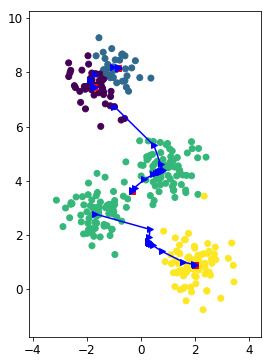

Heterogeneity values: 222.893863061


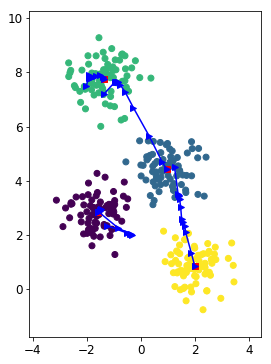

In [95]:
# generate dataset
X, y = make_blobs(n_samples = 300, centers = 4,
                  random_state = 0, cluster_std = 0.6)

# Parameter configuration
Nb_cluster =  4
numIterations = 100
data = X

# Run 2 cases with different initial centroids
for _ in range(2):
    # apply Kmeans alogorithm onto given dataset
    labels, centers, centers_Hist, heterogeneity = kmeans_heterogeneity(data, Nb_cluster, numIterations)
    print('Heterogeneity values:', heterogeneity)
    # plot the clustered dataset
    plot_kmeans(data, labels, centers, centers_Hist)

# Comment:
From the above two figures, we can see that a good clustering result can produce smaller heterogeneity (SSE) value than the bad one.

<div class="alert alert-block alert-info">
<strong>Question 5.</strong> Using the modified k-means method you designed, study algorithm convergence as a function of heterogeneity.

Follow the guidelines below:

<ul>
    <li>Run the modified k-means for at least 5 different initial seed values</li>
    <li>Prepare a dictionary data structure containing: key = random seed, value = heterogeneity</li>
    <li>Print seed, heterogeneity values</li>
</ul>

Add your personal comment about the convergence properties of the $k$-means algorithm.

</div>

In [97]:
# Compute heterogeneity values of k-means algorithm respecting to different initial centroids (or seeds)
seeds = np.random.choice(1000,5)
kmeansH_dict = {}
for seed in seeds:
    _, _, _, heterogeneity = kmeans_heterogeneity(data, Nb_cluster, numIterations, seed)
    kmeansH_dict[seed] = heterogeneity

print('Heterogeneity values (k-means) w.r.t different seeds:')
kmeansH_dict

Heterogeneity values (k-means) w.r.t different seeds:


{444: 222.89386306068891,
 376: 341.27620520989086,
 796: 222.89386306068891,
 156: 341.27620520989086,
 700: 222.89386306068891}

# Comment:
* Since a good clustering result should produce clusters in which data points should be very close to their centroids, and very far from other centroids then it gives a small heterogeneity (SSE) value. Therefore, heterogeneity value can indicates whether or not an good clustering is reached. As we can see from the above result of SSE values with different seed values (as well as different initial centroids ), some cases produce small SSE values (with respecting to good clustering) or some cases does not (bad clustering). 

* As explaining above, the performance of the k-means algorithm heavily depends on centroids initialization. In these cases, centroids are chosen randomly then some of them are not good, and the k-means algorithm will get stuck on local optima lead to bad clustering (as well as large heterogeneity value). So in practice, we should try many different initial centroids and get the best result.

***

# A technique for a smart centroid initialization: $k$-means++

One effective way to produce good initial centroids to feed to $k$-means is to proceed as follows: instead of randomly generating initial centroids, we will try to spread them out in our $d$-dimensional space, such that they are not "too close" to eachother. If you are interested in the details of this technique, you should refer to the link to the original research paper below: in summary, the $k$-means++ technique allows to improve the quality of the local optima in which $k$-means settles, and to reduce the average runtime of the algorithm.

k-means++: the advantages of careful seeding, by David Arthur and Sergei Vassilvitskii (Stanford University) https://dl.acm.org/citation.cfm?id=1283494

A simplified workflow of the $k$-means++ approach is as follows:


* Choose a data point at random from the dataset, this serves as the first centroid
* Compute the squared euclidean distance of all other data points to the randomly chosen first centroid
* To generate the next centroid, each data point is chosen with the probability (weight) of its squared distance to the chosen center in the current round, divided by the the total squared distance (this is just a normalization to make sure the probability adds up to 1). In other words, a new centroid should be as far as possible from the other centroids
* Next, recompute the probability (weight) of each data point as the minimum of the distance between it and all the centers that are already generated (e.g. for the second iteration, compare the data point's distance between the first and second center and choose the smaller one)
* Repeat step 3 and 4 until we have $k$ initial centroids to feed to the $k$-means algorithm


<div class="alert alert-block alert-info">
<strong>Question 6.</strong> Modify your own version of k-means, to introduce the smart initialization technique described above. Don't forget to keep track of heterogeneity as well! The whole point is to measure if k-means++ really improves on this metric.

<br>
<br>

Follow the guidelines below:

<ul>
    <li>Use the same method template you used in Question 1</li>
    <li>Add the code required to compute the initial clusters according to k-means++</li>
    <li>Add the code required to compute heterogeneity</li>
    <li>The function should return, in addition to the same return values as for the baseline version, the computed heterogeneity
</ul>
</div>

In [98]:
def initialize_centroids(X, k):
    '''
    
    Initialize centroids for Kmeans algorithm
    
    Arguments:
    X: data
    k: number of expected clusters
    
    Return:
    c: initial centroids
    
    '''
    c = np.empty((k, X.shape[1]))
    rand_indices = random.sample(range(len(X)), 1)
    c[0] = X[rand_indices]
    
    for i in range(1, k):
        # compute distance matrix
        distance_matrix = pairwise_distances(X, c, metric='euclidean')
        # compute the minimum of the distance between each datapoint and all the centers
        minDist = np.min(distance_matrix, axis = 1)
        # compute the probability (weight) of each data point
        prob = minDist/np.sum(minDist)
        # pick the next centroid
        idx = np.random.choice(len(X), 1, replace=False, p=prob)
        c[i] = X[idx]
    return c


def kmeanspp(X, k, maxiter, seed=None):
    '''
    An implement of Kmeans algorithm along with initial centroids ...
    
    Arguments:
    X                       --- data
    k                       --- number of expected clusters
    max_Iter                --- number of iterations that Kmeans should run
    seed                    --- integer starting value for seed() method

    Return:
    cluster_assignment      --- cluster label of data point
    new_centroids           --- updated centroids
    centroids_Hist          --- a list contains the centroid's position for each iteration.
    heterogeneity           --- total within Sum of Squares value
    
    '''
    if seed is not None:
        np.random.seed(seed)
    
    # choose k data points as initial centroids using ...
    init_centroids = initialize_centroids(X, k)

    centroids_Hist = [init_centroids]
    old_centroids = init_centroids
    for itr in range(maxiter):
        # ---------------
        # ASSIGNMENT STEP
        # ---------------
        # compute the distance matrix between each data point and the set of centroids
        distance_matrix = pairwise_distances(X, old_centroids, metric='euclidean')
        # assign each data point to the closest centroid
        cluster_assignment = np.argmin(distance_matrix, axis=1)

        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = np.empty((k,2))
        for idx in range(k):
            Xk = X[cluster_assignment == idx]
            new_centroids[idx] = np.mean(Xk, axis=0)
    
        # STOP CONDITION
        # if the current and previous heterogeneity are equal then stop algorithm
        if np.array_equal(new_centroids, old_centroids):
            break
        
        old_centroids = new_centroids
        centroids_Hist.append(new_centroids)
    
    heterogeneity = compute_heterogeneity(distance_matrix, cluster_assignment)
    
    return cluster_assignment, new_centroids, np.array(centroids_Hist), heterogeneity

Centers found by k-means++ algorithm:
 [[-1.58438467  2.83081263]
 [ 1.98258281  0.86771314]
 [ 0.94973532  4.41906906]
 [-1.37324398  7.75368871]]


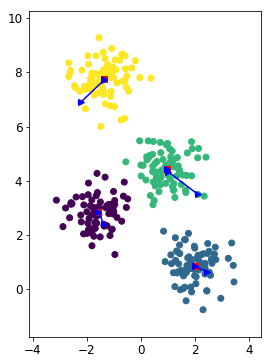

In [99]:
# Parameter configuration
Nb_cluster = 4
numIterations = 100
data = X
# apply Kmeans alogorithm onto given dataset
labels, centers, centers_Hist, _ = kmeanspp(data, Nb_cluster, numIterations)
print('Centers found by k-means++ algorithm:\n', centers)
# plot the clustered dataset
plot_kmeans(data, labels, centers, centers_Hist)

<div class="alert alert-block alert-info">
<strong>Question 7.</strong> Similarly to question 5, using the modified k-means method you designed, study algorithm convergence as a function of heterogeneity.
<br>
<br>


Follow the guidelines below:

<ul>
    <li>Run the modified k-means for at least 5 different initial seed values</li>
    <li>Prepare a dictionary data structure containing: key = random seed, value = heterogeneity</li>
    <li>Print seed, heterogeneity values</li>
</ul>

<br>

One additional question to answer is the following: print the average heterogeneity for the baseline k-means algorithm, and the average heterogeneity when using the k-means++ initialization. Compare and comment with your own words.
</div>

In [100]:
# Compute heterogeneity values of k-means++ algorithm respecting to different number of cluster values (K)
kmeanspp_dict = {}
for seed in seeds:
    _, _, _, heterogeneity = kmeanspp(data, Nb_cluster, numIterations, seed)
    kmeanspp_dict[seed] = heterogeneity

print('Heterogeneity values (k-means++) w.r.t different seeds:')
kmeanspp_dict

Heterogeneity values (k-means++) w.r.t different seeds:


{444: 222.89386306068891,
 376: 222.89386306068891,
 796: 341.2491079096946,
 156: 222.89386306068891,
 700: 222.89386306068891}

In [101]:
print("Average heterogeneity for the baseline k-means algorithm: ",np.average(list(kmeansH_dict.values())))
print("Average heterogeneity when using the k-means++ initialization: ",np.average(list(kmeanspp_dict.values())))

Average heterogeneity for the baseline k-means algorithm:  270.24679992
Average heterogeneity when using the k-means++ initialization:  246.56491203


# Comment:
* In these cases, centroids are chosen strategically then the performance can be better than the baseline. However, in some cases, the k-means++ can get stuck in local optima with bad initial centroid, resulting in bad clustering (large SSE value). Since centroid initialization is still based on probability to pick the next centroid point (does not pick the point that has the furthest distance) that can produce bad initial centroid. But in general, k-means++ still perfroms better than the baseline k-means.

***

# Determining the value of k: a simple and visual approach, called the Elbow method

Another problem of $k$-means is that we have to specify the number of clusters $k$ before running the algorithm, which we often don't know a priori. 
There are many different heuristics for choosing a suitable value for $k$, the simplest one being the **Elbow method**. Essentially, the idea is to run the $k$-means algorithm using different values of $k$ and plot the corresponding heterogeneity. This measure will decrease as the number of clusters increases, because each cluster will be smaller and tighter. 
By visual inspection of the plot heterogeneity vs. $k$, we will (hopefully!) see that the curve flattens out at some value of $k$: this is what we call an "elbow", and we'll select the value of $k$ corresponding to the "elbow" position.


<div class="alert alert-block alert-info">
<strong>Question 8.</strong> Using the k-means algorithm you implemented, including the smart initialization technique, collect into an array the value of heterogeneity as a function of the number of clusters k, where k is to be selected in the range [2,10].
<br>
<br>


Your output cell should contain:

<ul>
    <li>The plot of heterogeneity vs. k</li>
    <li>A discussion on your visual inspection of the curve, together with a justification for an appropriate choice of the value k</li>
</ul>
</div>

Text(0.5,1,'Heterogeneity vs Number of clusters')

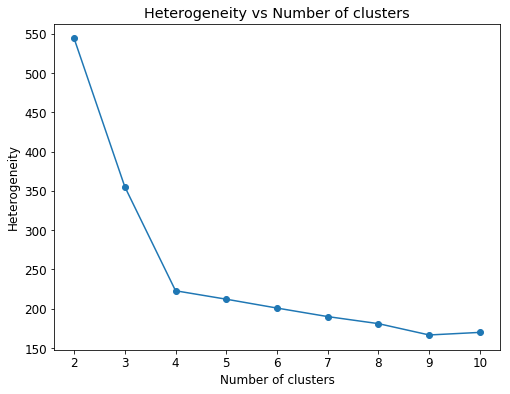

In [102]:
# Compute heterogeneity values (H) of k-means algorithm respecting to different number of cluster values (K)
K = np.arange(2, 11)
H = []
for k in K:
    Nb_cluster =  k
    numIterations = 100
    data = X
    _, _, _, h = kmeanspp(data, Nb_cluster, numIterations)
    H.append(h)

# The plot of heterogeneity vs number of clusters
plt.plot(K,H,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Heterogeneity')
plt.title('Heterogeneity vs Number of clusters')

# Comment:
* K-means is a simple unsupervised machine learning algorithm that groups a dataset into a user-specified number (k) of clusters. The algorithm is somewhat naive as it arranges the data into k clusters, even if k is not the right number of clusters to use. Therefore, when using k-means clustering, users need some way to determine whether they are using the right number of clusters.

* The idea is that we want a small SSE (good clustering), but that the SSE tends to decrease toward 0 as we increase k (the SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its cluster, and there is no error between it and the center of its cluster). So our goal is to choose a small value of k that still has a low SSE, and the elbow-method usually represents where we start to have diminishing returns by increasing k.

* As above we see an elbow chart showing the SSE after running k-means clustering for k clusters going from 2 to 10. We see a pretty clear elbow at k = 4, indicating that 4 is the best number of clusters.

***

# Distributed $k$-means with PySpark

We're now ready to work on a distributed implmentation of the $k$-means algorithm, using the PySpark API.

By now, you should be rather familiar with the $k$-means algorithm, which means we can focus on its parallel and distributed design.

## Distributed algorithm pseudo code

The basic idea of distributed $k$-means is as follows: data points to be clustered should be stored as a distributed dataset, namely a RDD. As in the Notebook on distributed SGD, we will take a shortcut and avoid using HDFS RDDs: rather, we'll use sklearn to generate the data points, similary to the serial version of the algorithms, then use the ```parallelize()``` method to create an RDD, and determine the number of partitions.

We also need to manipulate the centroids array: indeed, all machines should hold a copy of the centroid vector, such that they can proceed independently and in parallel in the first phase of the $k$-means algorithm, that is the **assignment step**. Specifically, every worker has a set of data points, and it will use a copy of the centroid vector to compute cluster assignement: we compute the distance between each data point and each centroid, to assign data points to their closest centroid.

Once the assignement step is done, we need to recompute new centroids based on the assignement, that is, we execute the **update step**. Clearly, we will need to **shuffle** data over the network such that we will have, for each current centroid, the list of all data points that have been assigned to it. If you think about it, this problem should be familiar!! This is very similar to what we do in the Word Count example. As such, you will need to make sure the output of the update step is cast to a ```<key, value>``` type, where the key corresponds to a centroid identifier, and the value contains the list of data points associated to that centroid. The framework will take care of the distributed group by operation, and organize data according to the semantic of our algorithm.

**NOTE:** since we will (potentially) work on large dataset sizes, we don't want our algorithm to return the final assignement after convergence, for otherwise we would need to collect a large amount of data in the driver machine, which has a finite and somehow limited amount of RAM.

The pseudo code of the algorithm you need to implement is as follows:

```python
datapoints = # Use sklearn, as usual, and work on blobs
centroids = # Random initialization

for itr in range(maxiter): # This for loop is executed by the driver
    bcCentroids = sc.broadcast(centroids) # Use broadcast variables
    
    closest = datapoints.mapPartition(assignement_step) # This should happen in parallel
    
    centroids = closest.reduceByKey(update_step_sum). \ # This should happen in parallel
        map(update_step_mean). \ # This should happen in parallel
        collect() # Here we collect new centroids in the driver
```

As you can see from the pseudo code, you need to figure out how to implement the ```assignement_step``` function and the update_step function. For the latter, the pseudo code gives you a big hint! Remember what we discussed in class about computing the mean!

<div class="alert alert-block alert-info">
<strong>Question 9.</strong> Implement the distributed version of the k-means algorithm, following the guidelines in the pseudo code.
<br>
<br>

Your output cell should contain:

<ul>
    <li>The value of the centroids once the algorithm converges</li>
    <li>The total runtime of the distributed algorithm, in seconds</li>
    <li>A visualization of the data points and the computed centroids</li>
</ul>
</div>

In [107]:
from scipy.spatial.distance import euclidean as dis
def kmeans_distributed(X, k, N, maxIter):
    '''
    An implement of Kmeans algorithm onto distributed dataset
    
    Arguments:
    X                   --- data
    k                   --- number of expected clusters
    N                   --- number of partitions to cut the dataset into
    max_Iter            --- number of iterations that Kmeans should run

    Return:
    cluster_assignment  --- cluster label of data point
    new_centroids       --- updated centroids
    centroids_Hist      --- a list contains the centroid's position for each iteration.
    heterogeneity       --- total within Sum of Squares value
    
    '''
    # randomly choose k data points as initial centroids
    rand_indices = random.sample(range(len(X)), k)
    init_centroids = X[rand_indices]
    
    # parallelize data collection
    dataRDD = sc.parallelize(X, N)

    # create read-only variables (centroids) cached on each machine
    bc_centroids = sc.broadcast(init_centroids)

    def assignment_step(data):
        '''
        Assign label for each data point

        '''
        c = bc_centroids.value
        for p in data:
            d = list(map(lambda x: dis(p, x), c))
            label = np.argmin(d)
            yield (label, [p,1])

    def update_step_sum(c1, c2):
        '''
        Take sum value of two centroids

        Arguments:
        c1          --- the first centroid
        c2          --- the second centroid

        Return:
        sumC        --- sum value of two centroids
        count       --- count for taking average later

        '''
        sumC = c1[0]+c2[0]
        count = c1[1]+c2[1]
        
        return ((sumC, count))
        

    def update_step_mean(res):
        '''
        Compute centroid value of each cluster

        Arguments:
        res         --- result from update_sum_step containing (sumC, count)

        Return:
        mean        --- centroid value of each cluster

        '''
        sumC = res[1][0]
        count = res[1][1]
        mean = sumC/count
        
        return mean 

    old_centroids = np.array(init_centroids)

    for i in range(maxIter):

        # ASSIGNMENT STEP
        # assign each data point to the closest centroid
        labelRDD = dataRDD.mapPartitions(assignment_step)
        
        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = np.array(labelRDD.reduceByKey(update_step_sum).map(update_step_mean).collect())
        
        # STOP CONDITION
        # if the current and previous heterogeneity are equal then stop algorithm
        if np.array_equal(new_centroids, old_centroids):
            break
        
        old_centroids = new_centroids
        bc_centroids = sc.broadcast(new_centroids)
    cluster_assignment = np.array(labelRDD.keys().collect())
    
    return cluster_assignment, new_centroids

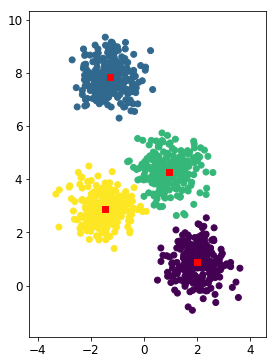

In [104]:
# generate dataset
X, y = make_blobs(n_samples = 1000, centers = 4,
                  random_state = 0, cluster_std = 0.6)

# parameter configuration
Nb_partition = 6
Nb_cluster = 4
numIterations = 100
data = X

# apply distributed Kmeans alogorithm onto given dataset
labels, centers= kmeans_distributed(data, Nb_cluster, Nb_partition, numIterations)

# plot the clustered dataset
plot_kmeans(data, labels, centers)

<div class="alert alert-block alert-info">
<strong>Question 10.</strong> Answer the following questions:
<br>
<br>
<ul>
    <li>How many partitions did you use? Why?</li>
    <li>What is the size of the dataset you generate? Did you cache the dataset? What's the RAM occupation?</li>
    <li>What is the size of the shuffle data over the network? How does it compare to the dataset size?</li>
</ul>
</div>

In [105]:
import sys
datasize = sys.getsizeof(X)/1024
print("Dataset size:", datasize)

Dataset size: 15.734375


# Comment:
* How many partitions did you use? Why?
    * The optimal number of partitions we should divide dataset should be the same with the number of total cores in the cluster. Our cluster contains 2 workers (each worker has 3 cores and 10.5 GB memory). Therefore, we divide our data into 6 partitions.
    
    
* What is the size of the dataset you generate? Did you cache the dataset? What's the RAM occupation?
    * The size of the generated dataset is nearly 15.7 KB. This number is obtained by using getsizeof() method of sys Python package. We had to cache the dataset after parallelizing it in order to store the parallelized version for later uses. If we don't cache the dataset, each time we call datapoints.mapPartitions, the raw dataset will be parallelized again due to lazy operations of Spark. Observing on Spark master web interface, this dataset cost 46.1 KB of RAM capacity.
    

* What is the size of the shuffle data over the network? How does it compare to the dataset size?
    * The size of the shuffle data over the network is 6.6 KB. It is smaller than the dataset size. Actually, we did experiment on the different dataset size (4.8KB, 15.7KB, 156.4KB, ...) all these cases have shuffle 6.6 KB data over the network. That means each worker machine take aggregate in advance tuple with the same key (cluster) on each partition (then reduce the amount of data) before sending over the network to perform shuffle. Hence, the size of the shuffle data over the network int this case only depend on the number of key (cluster) and does not depend on the size of input dataset.

<div class="alert alert-block alert-info">
<strong>Question 11.</strong> Comparison between serial and distributed implementations.
<br>
<br>
Given the dataset size you chose for your experiments, answer the following questions:
<ul>
    <li>Which is "faster", the serial or distributed implementation of k-means?</li>
    <li>What is a dataset size for which the distributed implementation is clearly faster than the serial one?</li>
    <li>What would be different in your code, should the input dataset reside on disk? Clearly, the input RDD would be reading from HDFS. Any other differences with respect to partitions?</li>
</ul>
</div>

In [106]:
# Compute the computation time of the serial implementation of k-means
before = time.time()
kmeans(data, Nb_cluster, numIterations)
after = time.time()
serial_time = after - before
print("Running time of the serial k-means", serial_time )

# Compute the computation time of the distributed implementation of k-means
before = time.time()
kmeans_distributed(data, Nb_cluster, Nb_partition, numIterations)
after = time.time()
distributed_time = after - before
print("Running time of the distributed k-means", distributed_time)

Running time of the serial k-means 0.01233530044555664
Running time of the distributed k-means 1.9322588443756104


# Comment:
* Which is "faster", the serial or distributed implementation of k-means?
    * Implement the serial or distributed k-means onto the generated dataset, the serial version run faster that the distributed one. In this case, the dataset can be fit into memory then there are no need to distribute the dataset into different machines. The drawback of  distributed implementation in this case is it costs time to distribute data as well as aggregate results from worker machines while serial implementation can do it in only one machine.


* What is a dataset size for which the distributed implementation is clearly faster than the serial one?
    * In the case that the dataset size can not fit into memory, the distributed implementation is clearly faster than the serial one. Since in this case, the data implemented by serial version will be read into memory sequentially and cause bottleneck. 


* What would be different in your code, should the input dataset reside on disk? Clearly, the input RDD would be reading from HDFS. Any other differences with respect to partitions?
    * If the input dataset resides on disk then it should be divided into different blocks and stored on different machines. Consequently, the file is already operated in parallel and it does not need to be recalled as the "parallelize collection" process.
    * The SparkDriver can manage the locations of the DataNode via NameNode in HDFS, and it also prioritizes on "Locality" processing. Hence, it will focus on accomplishing the tasks which closer to the data in order to minimize the data transferring time (avoid network I/O). That means it will consider processing the data on the same machine, then on the same Rack.